# Muscle sympathetic nerve activity (MSNA) burst detection

For this open-ended project, your goal is the detect bursts in muscle sympathetic nerve activity (MSNA). 

For a review of this data, consider rewatching the recorded talk by Miguel Anselmo (it can be found on Canvas), or check out these sources:
 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7907024/
 - https://pubmed.ncbi.nlm.nih.gov/34705589/

---

**READ THIS:** While this project is open-ended, we have a few requirements for your solution:
1. Your solution must be a machine learning approach. It must somehow **learn** 
from some set of training data, and make out-of-fold predictions on a testing set.
2. You can use any loss-function, or metrics for *internal* comparison, BUT your final
submission and write-up must report the *out-of-fold* f1 score (be careful not to leak 
data!) directly from the `msna_metric()` function. 
3. The notebook must be able to be run on a 8GB GPU (or CPU) in under 6 hours, this includes
training. 

Failure to comply with these requirements may lead to a low grade.

Below we give a general outline of how you might choose to structure your code. You do not
have to follow it exactly, and can reorganize it as long as you abide by the requirements
above. 

---

**Grading Rubric:**

Solution (80%)
 - Working ML solution following the guidelines with average F1 exceeding the baseline in both released and heldout datasets: 100%
 - A decent attempt using an ML approach following the guidelines, beating the baseline in the released data but not beating the baseline in heldout: 75%
 - Not beating baseline in both datasets, but a valid ML solution: 50%
 - A non ML solution or not attempted: 0%

Writeup (20%)
 - Explanation of how the problem was transformed into an ML task.
 - Explanation of the ML model (including figures, equations, etc).
 - Any special tweaks to achieve better performance.
 - Explanation of inter-patient performance (F1, etc.) variability and any figures/results related to that.
 
---


In [1]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd 
import numpy as np
import glob
import os

# Utilities for computing metrics based on this task.
from metrics import *

### Utilities 

Below are some utilities largely for standardizing data. They are not required to 
use, although you may find some of them useful for this project.

In [2]:
# For filtering and standardization of the timeseries signals
from scipy.signal import butter
from scipy.signal import filtfilt

def butter_filter(signal, fs = 200, cutoff_freq = [0.10, 50], order = 4, btype = "bandpass"):
    """Applies a butterworth bandpass filter to an input signal."""
    cutoff = np.asarray(cutoff_freq)
    b, a = butter(
        N = order, 
        Wn = cutoff / (0.5 * fs), 
        btype = btype,
        analog = False
    )
    return filtfilt(b, a, signal)

def standardize_percentile(y: np.ndarray, l: int, r: int) -> np.ndarray:
    """Standardizes a signal (y) using the percentile method.""" 
    lp = np.percentile(y, l)
    rp = np.percentile(y, r)
    y = (y - lp) / (rp - lp)
    return y


### Loading & Visualizing the Data

Change the data directory (`data_dir`) below to match your current setup. 

In the following cells, we will get the data, and load in an example slice. 

In [3]:
# Modify this to your data directory
data_dir = "./msna-data"


# DO NOT modify. Sorting for reproducibility.
all_paths = sorted(glob.glob(os.path.join(data_dir, "*")))

In [4]:
print(len(all_paths))

all_paths[0]

19


'./msna-data/MSNA086.csv'

In [5]:
# Load and visualize a single sample

df = pd.read_csv(all_paths[0])
df.head(15) 

,Timestamp,ECG,NIBP,Respiratory Waveform,Raw MSNA,Integrated MSNA,ECG Peaks,Burst,Beat
0,145.512,0.202238,71.00223,0.001953,0.996875,0.013154,False,False,False
1,145.516,0.202238,71.06382,0.002344,1.964844,0.015184,False,False,False
2,145.520,0.202238,70.82000,0.001172,1.755469,0.016956,False,False,False
3,145.524,0.202238,70.41847,0.001563,0.472656,0.018370,False,False,False
4,145.528,0.202238,70.51506,0.002344,0.446094,0.019581,False,False,False
5,145.532,0.202156,70.56639,0.002344,1.451563,0.021022,False,False,False
6,145.536,0.202156,70.17594,0.000781,1.987500,0.023339,False,False,False
7,145.540,0.202156,69.93732,0.000781,0.868750,0.025912,False,False,False
8,145.544,0.202156,70.01697,0.003516,0.328125,0.027675,False,False,False
9,145.548,0.202156,70.00763,0.001953,1.337500,0.028940,False,False,False


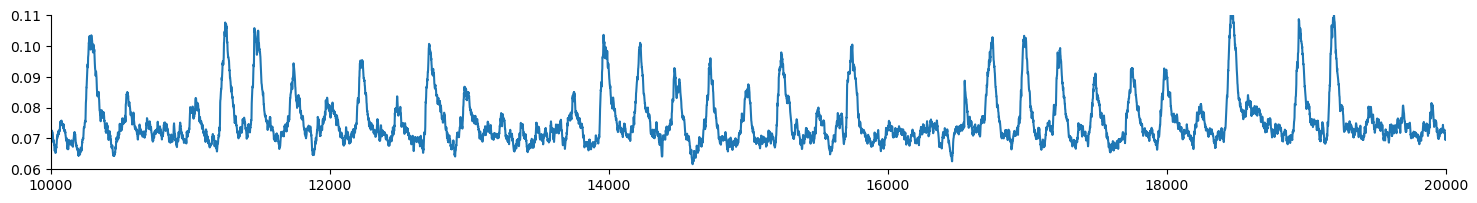

In [6]:
x = df["Integrated MSNA"]
    
plt.figure(figsize = (18, 2))
plt.plot(x)
plt.xlim(10_000, 20_000)
plt.ylim(0.06, 0.11)
sns.despine()
plt.show()

### Example: A Naive Peak-Finding Approach

Here we present a naive baseline solution that you have to beat both on the hidden test set that you don't have access to, and on the data you have access to.

For your solution, you CANNOT use peakfinding. The methodology must involve machine learning, or be
pre-approved by the TA or Professor. 

In [7]:
# What the baseline model will be based off of. 
from scipy.signal import find_peaks

def normalize_msna(msna: np.ndarray) -> np.ndarray:
    """
    Given an MSNA signal (integrated), we filter the signal first with the 
    butterworth bandpass filter to remove frequencies outside the range we 
    care about, and then normalize the signal into a common scale to aid in 
    peakfinding.
    """
    msna = np.asarray(msna)
    msna = butter_filter(msna, fs = 200, cutoff_freq = [0.15, 40.0])
    msna = standardize_percentile(msna, 5, 95)
    return msna

def find_msna_peaks(msna):
    msna = normalize_msna(msna)
    peaks = find_peaks(
        msna,
        height = 0.7,
        distance = 200,
        width = 40,
        rel_height = 0.5
    )[0]
    return peaks
        

In [8]:
df.shape

(150247, 9)

In [9]:
df['Burst'].value_counts()

Burst
False    149701
True        546
Name: count, dtype: int64

In [10]:
df['Beat'].value_counts()

Beat
False    149668
True        579
Name: count, dtype: int64

In [11]:
from sklearn.model_selection import KFold

# You should do some sort of cross-validation of your model, and present the mean 
# out-of-fold performance in your write-up. You are allowed/encouraged to reorganize
# this cell (and others) to fit your needs.
k_fold = KFold(n_splits = 5, shuffle = False)

scores = []
for train_inds, test_inds in tqdm(k_fold.split(all_paths), total = 5):
    
    for i in train_inds:
        # Because this example solution is not a machine learning approach, no 
        # training is required. Your "machine learning" based solution will have
        # to learn from data (unlike this example).
        pass
    
    for i in test_inds:
        df = pd.read_csv(all_paths[i])
        
        y_pred = find_msna_peaks(df["Integrated MSNA"])
        y_true = peaks_from_bool_1d(df["Burst"])

        # Because the MSNA spikes are phase-locked with the R-wave of the ECG signal, 
        # the metric looks between each ECG peaks and compares the `y_pred` and 
        # `y_true` arrays between each ECG peak to evaluate classification performance. 
        ecg_peaks = peaks_from_bool_1d(df["ECG Peaks"])

        # We have the metric defined for you. Your model output should only change the 
        # `y_pred` input to this metric. Do not modify how the `y_true` or `ecg_peaks`
        # is computed for the sake of this assignment. 
        f1 = msna_metric(y_pred, y_true, ecg_peaks)
        scores.append(f1)
        
        
print("F1 Score:")
print("Mean", "|", np.mean(scores))
print(" Std", "|", np.std(scores))
print(" Max", "|", np.max(scores))
print(" Min", "|", np.min(scores))

  0%|          | 0/5 [00:00<?, ?it/s]

F1 Score:
Mean | 0.7476163799594011
 Std | 0.1047106810594708
 Max | 0.9110889110889111
 Min | 0.5555555555555556


### Visualizing Model Performance

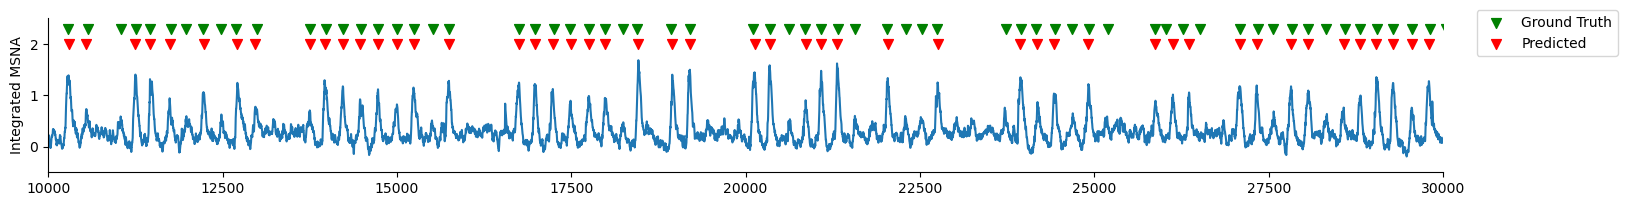

In [12]:
df = pd.read_csv(all_paths[0])

pred_peaks = find_msna_peaks(df["Integrated MSNA"])
true_peaks = peaks_from_bool_1d(df["Burst"])
ecg_peaks = peaks_from_bool_1d(df["ECG Peaks"])

# Plot the performance
plt.style.use("default")
plt.figure(figsize = (18, 2))
plt.plot(normalize_msna(df["Integrated MSNA"]))

plt.scatter( # Ground truth markers
    x = true_peaks,
    y = [2.3 for _ in range(len(true_peaks))],
    color = "green",
    marker = "v",
    label = "Ground Truth",
    s = 50
)
plt.scatter( # Predicted markers
    x = pred_peaks,
    y = [2 for _ in range(len(pred_peaks))],
    color = "red",
    marker = "v",
    label = "Predicted",
    s = 50
)

plt.ylabel('Integrated MSNA')
plt.xlim([10_000, 30_000])
plt.ylim([-0.5, 2.5])
plt.legend(
    loc = "upper right", 
    bbox_to_anchor = (1.13, 1.1), 
    frameon = True
)
sns.despine()
plt.show()

# CNN-LSTM based model for Burst Detection

In [13]:
all_paths

['./msna-data/MSNA086.csv',
 './msna-data/MSNA092.csv',
 './msna-data/MSNA094.csv',
 './msna-data/MSNA096.csv',
 './msna-data/MSNA111.csv',
 './msna-data/MSNA123.csv',
 './msna-data/MSNA126.csv',
 './msna-data/MSNA130.csv',
 './msna-data/MSNA132.csv',
 './msna-data/MSNA142.csv',
 './msna-data/MSNA143.csv',
 './msna-data/MSNA148.csv',
 './msna-data/MSNA153.csv',
 './msna-data/MSNA154.csv',
 './msna-data/MSNA163.csv',
 './msna-data/MSNA187.csv',
 './msna-data/MSNA204.csv',
 './msna-data/MSNA206.csv',
 './msna-data/MSNA207.csv']

In [14]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import random

seed = 44
random.seed(seed)  
np.random.seed(seed)  
torch.manual_seed(seed)  
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False  

# Create windows

Input: 
- data
- window size
- feature columns
- target column

Output:
- Tensor dataloader with data within the sequence

For the data in that window:
- the ECG is shift by ~1.2s because we can expect a burst roughly after 1.2 seconds after an ECG peak.
- NaN values are filled with 0.
- for the target, if any one row has a 1, then the target variable for the window is set to 1, else 0.

In [15]:
def create_windows(data, window_size, feature_cols=[ 'Integrated MSNA','ECG', 'ECG shift'], target_col='Burst'):
    sequences = []
    targets = []
    fs = 200  # Sampling frequency
    delay_samples = int(1.2 * fs)

    # Shift and normalize
    data['ECG shift'] = data['ECG'].shift(periods=delay_samples)
    data['Integrated MSNA'] = normalize_msna(data['Integrated MSNA'])
    data.fillna(0, inplace=True)  # Fill any NaN values

    num_windows = len(data) // window_size  # Determine the number of full windows

    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size

        # Extract features and target for the window
        seq = data.iloc[start_idx:end_idx][feature_cols].values
        target_values = set(data.iloc[start_idx:end_idx][target_col].values) 

        # Check for presence of 1 
        target = 1 if 1 in target_values else 0

        sequences.append(seq)
        targets.append(target)

    # Convert to PyTorch tensors
    feature_tensor = torch.tensor(np.array(sequences), dtype=torch.float32)
    target_tensor = torch.tensor(np.array(targets), dtype=torch.long)

    # Create TensorDataset and DataLoader
    dataset = TensorDataset(feature_tensor, target_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    return dataloader


# CNN - LSTM model

CNNs is great at extracting local patterns (e.g., bursts in MSNA signals), and LSTMs capture temporal dependencies, making it best for capturing bursts in temporal data.

In [16]:
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters=32, kernel_size=3, dropout_rate=0.5):
        super(SimpleLSTM, self).__init__()
        
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout_cnn = nn.Dropout(p=dropout_rate)  # Dropout for CNN layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout_fc = nn.Dropout(p=dropout_rate)  # Dropout for Fully Connected layer

    def forward(self, x):
        # Permute to [batch_size, input_channels, sequence_length]
        x = x.permute(0, 2, 1)

        # CNN Layers
        x = self.conv1(x)  # Convolution
        x = self.relu(x)   # Activation
        x = self.pool(x)   # Pooling
        x = self.dropout_cnn(x)  # dropout after pooling for generalisation

        x = self.conv2(x)  # Convolution
        x = self.relu(x)   # Activation
        x = self.pool(x)   # Pooling
        x = self.dropout_cnn(x)  # dropout after pooling

        # Permute back to [batch_size, sequence_length, input_channels] for LSTM
        x = x.permute(0, 2, 1)

        # LSTM Layers
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        x, _ = self.lstm(x, (h0, c0))
        x = self.dropout_fc(x[:, -1, :])  # dropout before the fully connected layer

        # Fully Connected Layer
        x = self.fc(x)  # Use the last time step's hidden state for classification
        return x


# Remapping the predictions back to time series

For each window, if there is a burst, then the row with the highest value is identified as the burst and rest as 0. Get the predictions for the window and add to dataframe. return the dataframe.
 
- if there are multiple peaks in a window, There is a threshold applied and all above it are marked as peaks

In [17]:
def remap_predictions_to_timeseries(df, predictions, window_size, threshold=0.8):
    # Initialize a column for predicted bursts with zeros
    df['Predicted Burst'] = 0
    
    total_windows = len(df) // window_size

    for window_index in range(total_windows + 1):
        start_idx = window_index * window_size
        end_idx = start_idx + window_size

        # Ensure the window does not exceed the dataframe length
        if end_idx <= len(df):
            # Get the prediction for the current window
            current_prediction = predictions[window_index]

            if current_prediction == 1:
                # Find all values above the threshold in the window
                window_segment = df[start_idx:end_idx]
                peaks_above_threshold = window_segment[window_segment['Integrated MSNA'] > threshold]
                
                # Mark all peaks above the threshold as bursts
                for peak_idx in peaks_above_threshold.index:
                    df.at[peak_idx, 'Predicted Burst'] = 1

    return df


# Model training

In [18]:
# function to train the model
def train_model(model, test_data_loader, loss_function, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in test_data_loader:
            optimizer.zero_grad()
            outputs = model(inputs) #forward pass
            loss = loss_function(outputs, labels) #loss compuatation
            loss.backward() #backward pass
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(test_data_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
        

In [19]:
def predict(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, _ in test_dataloader:
            inputs = inputs.to(next(model.parameters()))
            inputs = inputs.permute(0, 1, 2)  # Permute to [batch_size, num_features, sequence_length]
            
            # Forward pass through the model
            outputs = model(inputs)

            # Get predicted class indices
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())  # Convert predictions to numpy and add to list

    return predictions


# Compute class weights

This function is used to calculate weights for classes in our imbalanced dataset, ensuring that less frequent classes receive higher importance during model training. It iterates through the dataloader and counts occurrences of each class using torch.bincount. The weights are then calculated as the inverse of these counts, so classes with fewer samples get higher weights. 

In [20]:
def compute_class_weights(dataloader, num_classes):
    class_counts = torch.zeros(num_classes)
    for _, labels in dataloader:
        class_counts += torch.bincount(labels, minlength=num_classes)
    
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum() * num_classes  # Normalize weights
    return class_weights


# K fold training and evaluation

K fold cross validation is used and the data is trained and tested. Finally, the f1 score is calculated using the custom function. The f1 score mean, min, max, and std deviation is printed.

In [21]:
from sklearn.model_selection import KFold
import torch.optim as optim


scores = []
window_size = 100
num_epochs = 15
input_size = 3  # Number of features per time step
hidden_size = 64
num_layers = 2
output_size = 2  # Binary classification
num_filters = 32
kernel_size = 3

k_fold = KFold(n_splits = 5, shuffle = False)

for train_idx, test_idx in tqdm(k_fold.split(all_paths), total = 5):
    # Concatenating data from all training files
    train_data = pd.concat([pd.read_csv(all_paths[i]) for i in train_idx], ignore_index=True)
    train_data_preprocessed = create_windows(train_data, window_size)

    # Concatenating data from all test files
    test_data = pd.concat([pd.read_csv(all_paths[i]) for i in test_idx], ignore_index=True)
    test_data_preprocessed = create_windows(test_data, window_size)

    #Defining the model and hyper-parameters
    model = SimpleLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                output_size=output_size, num_filters=num_filters, kernel_size=kernel_size)

    num_classes = output_size  # Number of output classes
    class_weights = compute_class_weights(train_data_preprocessed, num_classes)

    # Define loss function with weights
    loss_module = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training the model
    train_model(model, train_data_preprocessed, loss_module, optimizer, num_epochs)
    
    predictions = predict(model, test_data_preprocessed)
    result = remap_predictions_to_timeseries(test_data, predictions, window_size)
    
    y_pred = peaks_from_bool_1d(result["Predicted Burst"])
    y_true = peaks_from_bool_1d(result["Burst"])
    ecg_peaks = peaks_from_bool_1d(result["ECG Peaks"])

    f1 = msna_metric(y_pred, y_true, ecg_peaks)
    print(f1)
    scores.append(f1)

print("F1 Score:")
print("Mean", "|", np.mean(scores))
print(" Std", "|", np.std(scores))
print(" Max", "|", np.max(scores))
print(" Min", "|", np.min(scores))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/15, Loss: 0.5267, Accuracy: 81.88%
Epoch 2/15, Loss: 0.3954, Accuracy: 85.66%
Epoch 3/15, Loss: 0.3831, Accuracy: 85.54%
Epoch 4/15, Loss: 0.3698, Accuracy: 86.04%
Epoch 5/15, Loss: 0.3590, Accuracy: 85.61%
Epoch 6/15, Loss: 0.3562, Accuracy: 85.42%
Epoch 7/15, Loss: 0.3451, Accuracy: 85.46%
Epoch 8/15, Loss: 0.3416, Accuracy: 85.45%
Epoch 9/15, Loss: 0.3365, Accuracy: 85.58%
Epoch 10/15, Loss: 0.3314, Accuracy: 86.32%
Epoch 11/15, Loss: 0.3262, Accuracy: 85.94%
Epoch 12/15, Loss: 0.3230, Accuracy: 86.33%
Epoch 13/15, Loss: 0.3189, Accuracy: 86.36%
Epoch 14/15, Loss: 0.3180, Accuracy: 86.81%
Epoch 15/15, Loss: 0.3181, Accuracy: 86.43%
0.8485684718868575
Epoch 1/15, Loss: 0.4915, Accuracy: 70.91%
Epoch 2/15, Loss: 0.3746, Accuracy: 86.30%
Epoch 3/15, Loss: 0.3652, Accuracy: 85.61%
Epoch 4/15, Loss: 0.3574, Accuracy: 85.38%
Epoch 5/15, Loss: 0.3483, Accuracy: 85.11%
Epoch 6/15, Loss: 0.3459, Accuracy: 84.96%
Epoch 7/15, Loss: 0.3397, Accuracy: 85.15%
Epoch 8/15, Loss: 0.3368, Acc

# Visualisation

The predicted peaks are visualised against the ground truth peaks.

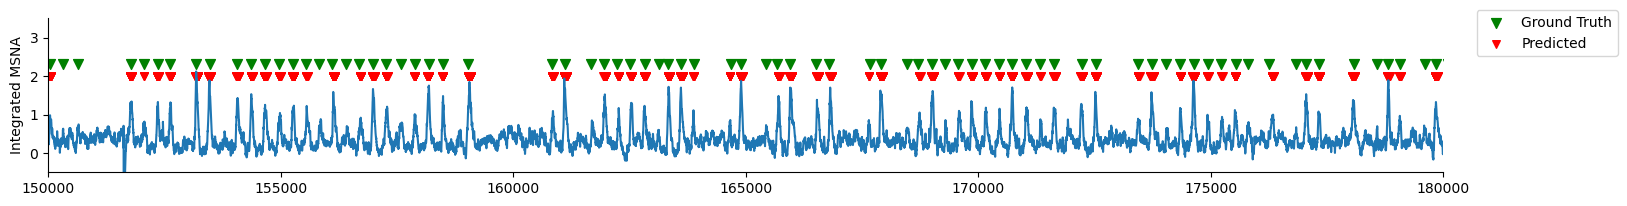

In [24]:
# Plot the performance
plt.style.use("default")
plt.figure(figsize = (18, 2))
plt.plot(normalize_msna(result["Integrated MSNA"]))

plt.scatter( # Ground truth markers
    x = y_true,
    y = [2.3 for _ in range(len(y_true))],
    color = "green",
    marker = "v",
    label = "Ground Truth",
    s = 50
)
plt.scatter( # Predicted markers
    x = y_pred,
    y = [2 for _ in range(len(y_pred))],
    color = "red",
    marker = "v",
    label = "Predicted",
    s = 30
)

plt.ylabel('Integrated MSNA')
plt.xlim([150_000, 180_000])
plt.ylim([-0.5, 3.5])
plt.legend(
    loc = "upper right", 
    bbox_to_anchor = (1.13, 1.1), 
    frameon = True
)
sns.despine()
plt.show()